## Evaluate linear regression model with a non-liner dataset - residual error plot

Linear regression is a statistic algorithm that provides a linear relationship between a set of features (independent variables). Based on this relationship, we can predict a numeric outcome. An example, we can have a series of data from real word and based on this we can predict a salary, price of a house, and sales.

The problem is that a linear regression model works best for a linear data set, but in a multi-dimensional space is impossible to know if the data we have is linear or not. In that case, how to know if the linear model is suitable for the data set?


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## MODELS ##
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge

## METRICS ##
# regression models
from sklearn.metrics import mean_absolute_error, mean_squared_error

C:\Users\alberto.beniste\.conda\envs\alberto_beniste\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Anscombe’s quartet

From Wikipedia, Anscombe’s Quartet can be defined as four data sets which are nearly identical in simple descriptive statistics by having the same variance, mean, and linear regression line, but have different data points when ploting on a graph.

Below are the graphs for Anscombe’s Quartet data set. The four data set has the same line that fits the data, but clearly only one data set best fit for a linear mode (dataset = I).

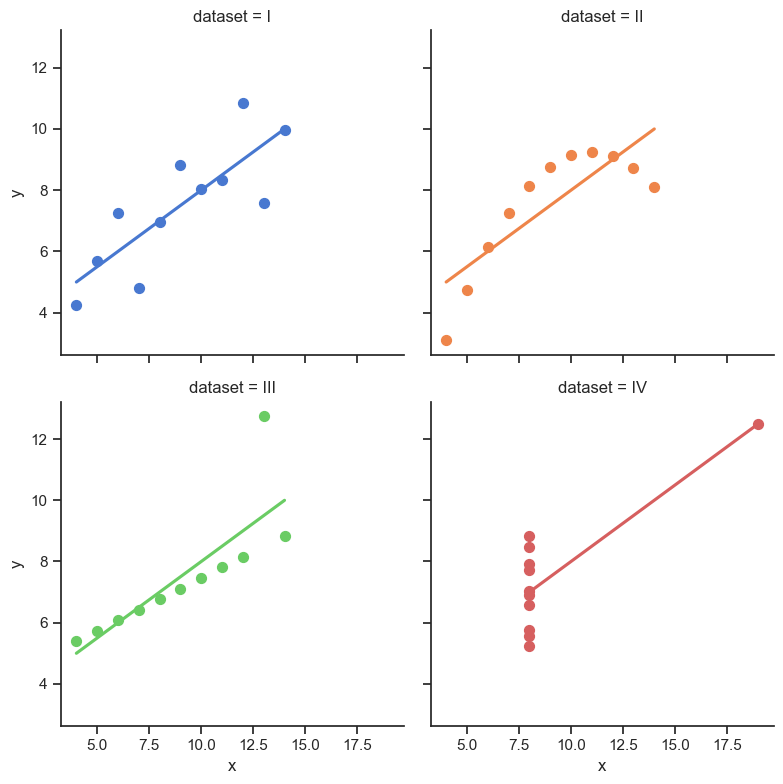

In [2]:
sns.set_theme(style="ticks")

# Load the example dataset for Anscombe's quartet
df = sns.load_dataset("anscombe")

# Show the results of a linear regression within each dataset
sns.lmplot(
    data=df, x="x", y="y", col="dataset", hue="dataset",
    col_wrap=2, palette="muted", ci=None,
    height=4, scatter_kws={"s": 50, "alpha": 1}
);

We can see from the graphs above that not all data set can be solved using linear models. At the same time, we cannot know if the data follows a linear relationship since we cannot plot a graph with dozens of features.

So, how to know if a linear model is suitble for a particular datapoint? That's where the residual error comes into play. We can plot residual error against y true values. 

### Data set 

Let's use the California housing data from sklearn.

In [3]:
# We use the the dataset California housing mareket, provided by scikit-learn
# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html

from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()

In [4]:
housing

{'data': array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
           37.88      , -122.23      ],
        [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
           37.86      , -122.22      ],
        [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
           37.85      , -122.24      ],
        ...,
        [   1.7       ,   17.        ,    5.20554273, ...,    2.3256351 ,
           39.43      , -121.22      ],
        [   1.8672    ,   18.        ,    5.32951289, ...,    2.12320917,
           39.43      , -121.32      ],
        [   2.3886    ,   16.        ,    5.25471698, ...,    2.61698113,
           39.37      , -121.24      ]]),
 'target': array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894]),
 'frame': None,
 'target_names': ['MedHouseVal'],
 'feature_names': ['MedInc',
  'HouseAge',
  'AveRooms',
  'AveBedrms',
  'Population',
  'AveOccup',
  'Latitude',
  'Longitude'],
 'DESCR': '.. _california_housing_dataset:\n

In [5]:
# Transform the result into a dataframe
house_df = pd.DataFrame(housing["data"], columns=housing["feature_names"])
house_df["target"] = pd.DataFrame(housing["target"])
house_df.head(4)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413


In [6]:
house_df.isnull().sum()

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
target        0
dtype: int64

In [7]:
# This is a classification model to predict heart disease.
X = house_df.drop(columns="target")
y = house_df["target"]

X.shape, y.shape

((20640, 8), (20640,))

In [8]:
def split_scaling_features(X, y, scaler, test_size=0.2, random_state=None):
    """
    Function that splits the features into train and test, and in addition, performs feature scaling.
    Parameters:
        X: features from the dataset
        y: label from the dataset
        scaler: the type of feature scaling method applied. It can be 'min_max' for MinMaxScaler(), 'max_abs' for MaxAbsScaler(),
                and 'std' for StandardScaler().
    Return:
        X_train, X_test, y_train, y_test
    """
    from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler
    from sklearn.model_selection import train_test_split
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    if (scaler == "min_max"):
        scaler = MinMaxScaler()
    elif (scaler == "max_abs"):
        scaler = MaxAbsScaler()
    elif (scaler == "std"):
        scaler = StandardScaler()
    else:
        scaler = StandardScaler()
    
    # compute the statistics only to the train set
    scaler.fit(X_train)
    
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

In [9]:
# split the data into train and test set, and also peform feature scaling using the function above.
X_train, X_test, y_train, y_test = split_scaling_features(X, y, scaler="min_max", test_size=0.3, random_state=7)

In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14448, 8), (6192, 8), (14448,), (6192,))

### Training and evaluate the model

Let's use Ridge model for this data set.

In [11]:
# Ridge add in a penalty which is the alpha parameter.
model = Ridge(alpha=10)

In [12]:
model.fit(X_train, y_train);

In [13]:
y_pred = model.predict(X_test)
y_pred

array([1.50830976, 2.44563118, 2.42321782, ..., 1.98800894, 6.75428431,
       4.31937116])

In [14]:
np.array(y_test)

array([3.6    , 3.36   , 2.699  , ..., 1.332  , 5.00001, 3.839  ])

In [15]:
house_df["target"].mean()

2.068558169089147

In [16]:
# we can compare the metric with the mean to have a sense how off the model is.
mae = mean_absolute_error(y_test, y_pred)
mae

0.5439130178954132

In [17]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
rmse

0.7355575456555951

### Residual plot

The perfect model would have residual equal to zero for all true labels when comparing with the predictions.

In [18]:
# the perfect model would have zero for all data points
residuals = y_test - y_pred
residuals

4648     2.091690
8740     0.914369
162      0.275782
15735    1.022876
18380    0.728822
           ...   
6291    -0.449278
5448     1.279022
14695   -0.656009
16171   -1.754274
10661   -0.480371
Name: target, Length: 6192, dtype: float64

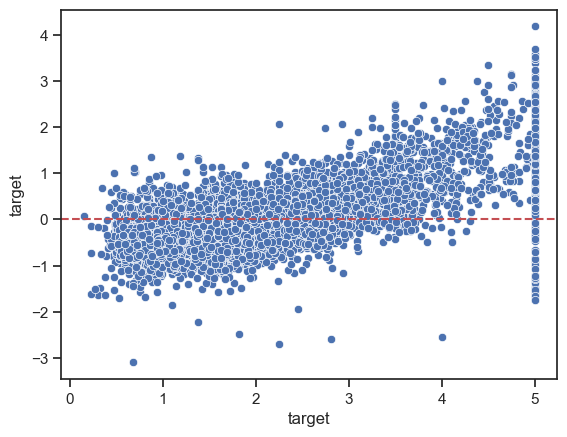

In [19]:
# The plot shold be distribuited around zero, but it seems that is kind of random.
sns.scatterplot(x=y_test, y=residuals)
plt.axhline(y=0, color="r", ls="--") # residual plot
plt.show();

The plot above should rise a red flag, since we have the residuals far from the residual plot (red line). We need to explore other models. 

That's the reason we need always be cautions when using linear regression type of model. We never know whether the data is linear behavior or not.

The residual plot is the best way to answer this question.

### Using a different model

Let's use a different model to quick evaluate its performance against the linear model above.

In [20]:
from sklearn.ensemble import RandomForestRegressor
model_rfr = RandomForestRegressor()
model_rfr.fit(X_train, y_train)
y_pred_rtf = model_rfr.predict(X_test)

In [21]:
mae_rf = mean_absolute_error(y_test, y_pred_rtf)
mae_rf

0.3430114086240312

In [22]:
rmse_rf = mean_squared_error(y_test, y_pred_rtf, squared=False)
rmse_rf

0.5210611554849045

We can see that Random Forest has a much better peformance than the linear regression.